In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:


transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader_cifar10 = torch.utils.data.DataLoader(train_data_cifar10, batch_size=64, shuffle=True)
test_loader_cifar10 = torch.utils.data.DataLoader(test_data_cifar10, batch_size=64, shuffle=False)



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])


train_data_cifar100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data_cifar100 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


train_loader_cifar100 = torch.utils.data.DataLoader(train_data_cifar100, batch_size=64, shuffle=True)
test_loader_cifar100 = torch.utils.data.DataLoader(test_data_cifar100, batch_size=64, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ProgressiveNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProgressiveNN, self).__init__()
        
        self.branch1 = nn.Sequential(
            nn.Linear(3072, 256),  
            nn.ReLU(),
            nn.Linear(256, output_dim)  
        )
        
       
        self.branch2 = nn.Sequential(
            nn.Linear(3072, 256),  
            nn.ReLU(),
            nn.Linear(256, 100)  
        )
        
    def forward(self, x, task_num):
        x = x.view(x.size(0), -1) 
        if task_num == 1:
            return self.branch1(x)
        elif task_num == 2:
            return self.branch2(x)


In [4]:

def get_optimizer(model, task_num, base_lr=0.001):
   
    if task_num == 1:
        return optim.Adam(model.branch1.parameters(), lr=base_lr)
    elif task_num == 2:
        return optim.Adam(model.branch2.parameters(), lr=base_lr * 0.5)  


In [5]:
class EWC:
    def __init__(self, model, dataset, importance=1000):
        self.model = model
        self.importance = importance
        self.params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        self.previous_means = {}
        self.fisher_matrix = self.compute_fisher_matrix(dataset)
    
    def compute_fisher_matrix(self, dataset):
        fisher_matrix = {}
        for name, param in self.params.items():
            fisher_matrix[name] = torch.zeros_like(param)
        
        model.eval()
        for data, label in dataset:
            self.model.zero_grad()
            output = self.model(data, task_num=1)  
            loss = torch.nn.functional.cross_entropy(output, label)
            loss.backward()
            for name, param in self.params.items():
                fisher_matrix[name] += param.grad.data ** 2  
        return fisher_matrix
    
    def penalty(self, model):
        loss = 0
        for name, param in model.named_parameters():
            if name in self.previous_means:
                fisher_penalty = self.fisher_matrix[name] * (param - self.previous_means[name]) ** 2
                loss += fisher_penalty.sum()
        return loss


In [6]:

task_accuracies = []
epochs_accuracies = []  

In [7]:
def train_with_visualization(model, train_loader, replay_buffer, ewc, task_num, num_epochs=1, test_loader=None):
    optimizer = get_optimizer(model, task_num)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs, task_num=task_num)
            loss = nn.CrossEntropyLoss()(outputs, labels)

           
            if ewc:
                loss += ewc.penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.3f}")
        
        
        if test_loader:  
            accuracy = evaluate_model_with_accuracy_tracking(model, test_loader, task_num)
            epochs_accuracies.append(accuracy)
    
    print(f"Training complete for Task {task_num} after {num_epochs} epochs.")


In [8]:
def evaluate_model_with_accuracy_tracking(model, test_loader, task_num):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs, task_num=task_num)  
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy for Task {task_num}: {accuracy:.2f}%")
    return accuracy


In [9]:
import matplotlib.pyplot as plt


def plot_task_accuracies(task_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(task_accuracies) + 1), task_accuracies, marker='o', linestyle='-', color='b', label='Task Accuracy')
    plt.title('Accuracy Per Task')
    plt.xlabel('Task Number')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_epoch_accuracies(epochs_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epochs_accuracies) + 1), epochs_accuracies, linestyle='-', color='r', label='Epoch Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.show()


In [10]:

class ReplayBuffer:
    def __init__(self, capacity=200):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0) 
        self.buffer.append(data)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None
        return random.sample(self.buffer, batch_size)
input_dim = 512 
output_dim = 10  

Epoch 1/50, Loss: 1287.454
Accuracy for Task 1: 47.75%
Epoch 2/50, Loss: 1136.086
Accuracy for Task 1: 48.35%
Epoch 3/50, Loss: 1070.587
Accuracy for Task 1: 50.28%
Epoch 4/50, Loss: 1019.984
Accuracy for Task 1: 50.54%
Epoch 5/50, Loss: 970.534
Accuracy for Task 1: 50.45%
Epoch 6/50, Loss: 923.848
Accuracy for Task 1: 51.60%
Epoch 7/50, Loss: 887.076
Accuracy for Task 1: 51.83%
Epoch 8/50, Loss: 849.544
Accuracy for Task 1: 51.61%
Epoch 9/50, Loss: 815.426
Accuracy for Task 1: 51.90%
Epoch 10/50, Loss: 786.547
Accuracy for Task 1: 51.06%
Epoch 11/50, Loss: 748.984
Accuracy for Task 1: 51.92%
Epoch 12/50, Loss: 718.471
Accuracy for Task 1: 51.66%
Epoch 13/50, Loss: 687.377
Accuracy for Task 1: 52.15%
Epoch 14/50, Loss: 665.325
Accuracy for Task 1: 51.89%
Epoch 15/50, Loss: 641.331
Accuracy for Task 1: 51.97%
Epoch 16/50, Loss: 611.262
Accuracy for Task 1: 51.55%
Epoch 17/50, Loss: 595.815
Accuracy for Task 1: 52.20%
Epoch 18/50, Loss: 578.001
Accuracy for Task 1: 51.30%
Epoch 19/50, Lo

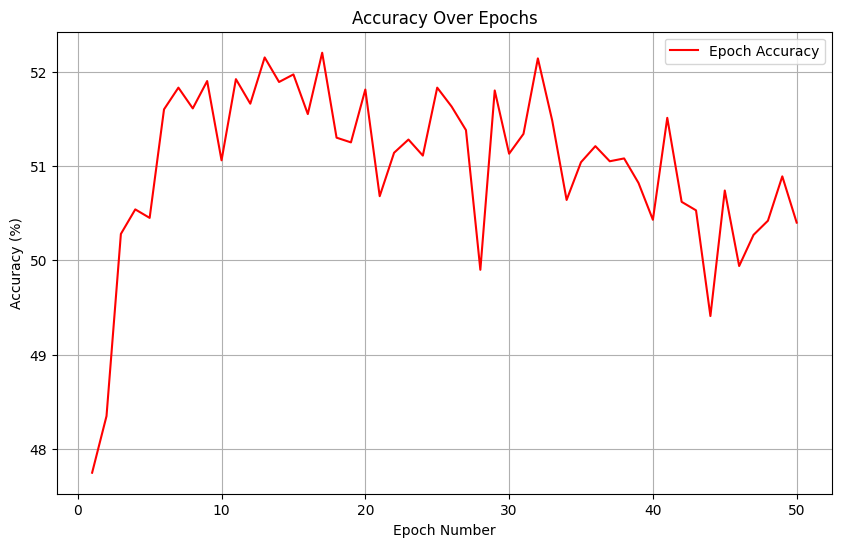

In [11]:

input_dim = 3072  
output_dim = 10   
model = ProgressiveNN(input_dim=input_dim, output_dim=output_dim)
test_loader_cifar10 = torch.utils.data.DataLoader(test_data_cifar10, batch_size=64, shuffle=False)
replay_buffer = ReplayBuffer(capacity=200)
train_with_visualization(model, train_loader_cifar10, replay_buffer, None, task_num=1, num_epochs=50, test_loader=test_loader_cifar10)
plot_epoch_accuracies(epochs_accuracies)

In [13]:
class OODHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OODHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

In [14]:
import torch.nn as nn
class WPHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WPHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

In [15]:
output_dim = 100  
ood_head = OODHead(input_dim=512, num_classes=output_dim)
wp_head = WPHead(input_dim=512, num_classes=output_dim)

In [16]:

output_dim = 100  
ood_head = OODHead(input_dim=512, num_classes=output_dim)
wp_head = WPHead(input_dim=512, num_classes=output_dim)
train_with_visualization(model, train_loader_cifar100, replay_buffer, None, task_num=2, num_epochs=50)


Epoch 1/50, Loss: 2921.715
Epoch 2/50, Loss: 2598.806
Epoch 3/50, Loss: 2440.935
Epoch 4/50, Loss: 2321.923
Epoch 5/50, Loss: 2222.483
Epoch 6/50, Loss: 2135.207
Epoch 7/50, Loss: 2055.089
Epoch 8/50, Loss: 1980.748
Epoch 9/50, Loss: 1917.113
Epoch 10/50, Loss: 1856.059
Epoch 11/50, Loss: 1799.286
Epoch 12/50, Loss: 1739.820
Epoch 13/50, Loss: 1690.154
Epoch 14/50, Loss: 1639.783
Epoch 15/50, Loss: 1593.917
Epoch 16/50, Loss: 1547.116
Epoch 17/50, Loss: 1503.936
Epoch 18/50, Loss: 1464.917
Epoch 19/50, Loss: 1426.342
Epoch 20/50, Loss: 1388.085
Epoch 21/50, Loss: 1349.464
Epoch 22/50, Loss: 1314.810
Epoch 23/50, Loss: 1288.751
Epoch 24/50, Loss: 1252.212
Epoch 25/50, Loss: 1220.239
Epoch 26/50, Loss: 1192.295
Epoch 27/50, Loss: 1164.829
Epoch 28/50, Loss: 1130.504
Epoch 29/50, Loss: 1108.984
Epoch 30/50, Loss: 1080.660
Epoch 31/50, Loss: 1056.902
Epoch 32/50, Loss: 1028.814
Epoch 33/50, Loss: 1004.373
Epoch 34/50, Loss: 977.658
Epoch 35/50, Loss: 959.570
Epoch 36/50, Loss: 936.261
Epoc

Epoch 1/50, Loss: 461.930
Epoch 2/50, Loss: 438.602
Epoch 3/50, Loss: 428.780
Epoch 4/50, Loss: 420.277
Epoch 5/50, Loss: 413.940
Epoch 6/50, Loss: 405.493
Epoch 7/50, Loss: 394.027
Epoch 8/50, Loss: 392.410
Epoch 9/50, Loss: 382.739
Epoch 10/50, Loss: 377.474
Epoch 11/50, Loss: 371.608
Epoch 12/50, Loss: 365.954
Epoch 13/50, Loss: 355.187
Epoch 14/50, Loss: 358.805
Epoch 15/50, Loss: 351.481
Epoch 16/50, Loss: 342.192
Epoch 17/50, Loss: 337.078
Epoch 18/50, Loss: 329.321
Epoch 19/50, Loss: 321.386
Epoch 20/50, Loss: 318.626
Epoch 21/50, Loss: 326.189
Epoch 22/50, Loss: 301.557
Epoch 23/50, Loss: 308.255
Epoch 24/50, Loss: 292.615
Epoch 25/50, Loss: 298.435
Epoch 26/50, Loss: 289.020
Epoch 27/50, Loss: 284.424
Epoch 28/50, Loss: 292.267
Epoch 29/50, Loss: 273.975
Epoch 30/50, Loss: 275.497
Epoch 31/50, Loss: 282.047
Epoch 32/50, Loss: 260.336
Epoch 33/50, Loss: 270.022
Epoch 34/50, Loss: 259.181
Epoch 35/50, Loss: 248.511
Epoch 36/50, Loss: 257.802
Epoch 37/50, Loss: 249.584
Epoch 38/5

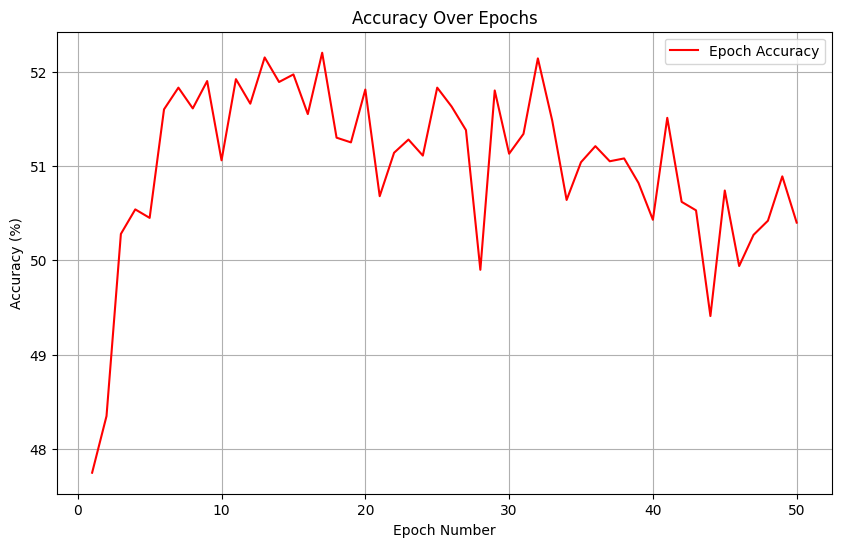

In [25]:
output_dim = 100


ood_head = OODHead(input_dim=512, num_classes=output_dim)
wp_head = WPHead(input_dim=512, num_classes=output_dim)



train_with_visualization(model, train_loader_cifar100, replay_buffer, None, task_num=2, num_epochs=50)


plot_epoch_accuracies(epochs_accuracies)




In [20]:
for inputs, labels in train_loader_cifar100:
    outputs = model(inputs, task_num=2)
    print(f"Model output shape: {outputs.shape}")  
    print(f"Labels: {labels}")
    break  


Model output shape: torch.Size([64, 100])
Labels: tensor([52, 39,  9, 52, 48, 94, 82, 41, 40, 48, 50, 26, 69, 82,  6,  4, 64, 94,
        47, 56, 78, 75, 66, 68, 77, 93, 78, 42, 75, 35, 66, 72, 91, 94, 71,  3,
        73, 75,  1, 31, 25, 14, 31, 18, 18, 57, 24, 49, 74,  6,  8, 67, 88, 46,
        92, 31, 39,  1, 24, 38, 71, 93, 98, 29])


In [21]:
for inputs, labels in train_loader_cifar100:
    outputs = model(inputs, task_num=2)
    print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
    print(f"Max label value: {labels.max().item()}, Expected output classes: {outputs.size(1)}")
    loss = nn.CrossEntropyLoss()(outputs, labels)
    print(f"Loss: {loss.item()}")
    break


Outputs shape: torch.Size([64, 100]), Labels shape: torch.Size([64])
Max label value: 99, Expected output classes: 100
Loss: 0.4611285626888275
